## Spiral Wave Generation Code

In [763]:
import os
import sys
sys.path.append(r"../")

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from base.node import FKnode, LRnode, HHnode, FHNnode
# from base.channel import CHR2
from base.method import difsys,TCD #, JCB, DLS, SynFactor, Electrode
# from base.plt import Plotter

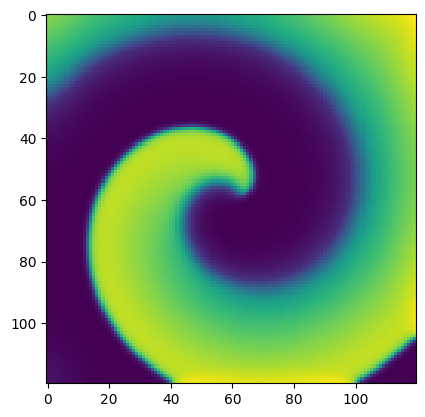

In [764]:
data = np.load(r"FK120.npy") # HH120.npy
plt.imshow(data[0].reshape(120,120), cmap='viridis')

In [765]:
number1 = 120*60+80 # resting state
data[0,number1]

0.004101306694586579

In [766]:
number2 = 120*60+40 # Spiking state
data[0,number2]

0.7731567219759937

In [767]:
v_mean = np.mean(data[0]) # Mean Membrane Potential
v_mean

0.4235466464856966

In [768]:
l = 120                                     
difmatrix = difsys(l)                       
conn_matrix, neighbor_list = difmatrix()    

############## FHN ###############
# node = FHNnode(dt = 0.01)
# FHN_data = np.load(r"FHN120.npy")
# v = FHN_data[0]
# w = FHN_data[1]
# vw = [v, w]
# node._initialize(vw)
# D = 0.1                           
# iext = np.full((l*l), 0.15)       
# JCB_th = 0.5                      
# v_max = 2.                        
# v_min = -2.                       

############### HH ###############
# node = HHnode(dt = 0.01)
# HH_data = np.load(r"HH120.npy")
# v = HH_data[0]
# m = HH_data[1]
# n = HH_data[2]
# h = HH_data[3]
# v=np.full((l*l), HH_data[0,number])
# m=np.full((l*l), HH_data[1,number])
# n=np.full((l*l), HH_data[2,number])
# h=np.full((l*l), HH_data[3,number])
# vmnh = [v, m, n, h]
# node._initialize(vmnh)
# D = 0.1865                  
# iext = np.full((l*l), 1.5)  
# JCB_th = 100.               
# v_max = 40.                 
# v_min = -85.                

############### FK ###############
node = FKnode(dt = 0.01)
FK_data = np.load(r"FK120.npy")
# v = FK_data[0]
# u = FK_data[1]
# w = FK_data[2]
v=np.full((l*l), FK_data[0,number1])
u=np.full((l*l), FK_data[1,number1])
w=np.full((l*l), FK_data[2,number1])
vuw = [v, u, w]
node._initialize(vuw)
D = 0.15                     
iext = np.full((l*l), 0.0)   
JCB_th = 0.01                
v_max = 1.                   
v_min = 0.                   

############### LR ###############
# node = LRnode(dt = 0.01)
# LR_data = np.load(r"LR120.npy")
# v = LR_data[0]
# m = LR_data[1]
# h = LR_data[2]
# j = LR_data[3]
# d = LR_data[4]
# f = LR_data[5]
# X = LR_data[6]
# Cai = LR_data[7]
# init_LR = [v, m, h, j, d, f, X, Cai]
# node._initialize(init_LR)
# D = 0.25                    
# iext = np.full((l*l), 0.0)  
# JCB_th = 100.               
# v_max = 20.                 
# v_min = -85.                


In [769]:
############# Generate data ############
sum_len = int(500/node.dt)
mem_data = np.zeros((l*l, sum_len))         
iopt = np.full((l*l,), 0.0)     

place = np.arange(0, l*l)  
result = [place[i * 120 + j] for i in range(120) for j in range(60)] # Find the nodes that belong to columns 1 through 60.

density = TCD(l, v_mean = v_mean)       # Instantiating TCD
vtime0 = node.v.reshape(l,l)            # Sampling v
tra = np.zeros((l, l))                  # PS tracks

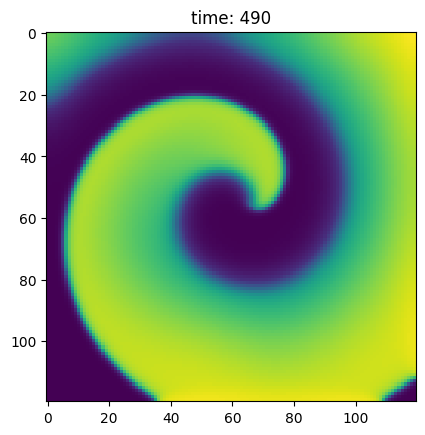

In [770]:
plt.ion()  # Open Interactive Mode
fig, ax = plt.subplots()

# running simulation
for i in range(sum_len):

    isyn = D * conn_matrix @ node.v             
    inputs = isyn + iext + iopt                 
    node.integral(inputs)                       
    mem_data[:,i] = node.v                      
    
    if i == 10/node.dt:
        node.v[1:2400]=FK_data[0,number2]
        node.u[1:2400]=FK_data[1,number2]
        node.w[1:2400]=FK_data[2,number2]
        # iopt[1:7200]=1.0    
        # iopt[1:2400]=10*np.sin(0.1*i/node.dt)

    else:
        iopt[:] = 0.0   
    if i == 200/node.dt:
        node.v[result]=FK_data[0,number1]
        node.u[result]=FK_data[1,number1]
        node.w[result]=FK_data[2,number1]
        # node.v[result]=HH_data[0,number]
        # node.m[result]=HH_data[1,number]
        # node.n[result]=HH_data[2,number]
        # node.h[result]=HH_data[3,number]

    if i % 1000==0:
        vtime1 = node.v.reshape(l, l)
        singularity, vtime0 = density(vtime1, vtime0)
        if i>1000:
            tra[singularity == 1] = 1

        clear_output(wait=True)  
        ax.clear()      
        ax.imshow(node.v.reshape(l, l), cmap='viridis') # membrane potential
        # ax.imshow(tra, cmap='viridis') # PS tracks
        ax.set_title(f'time: {int(i/100)}')
        display(fig)    
        plt.pause(0.1)


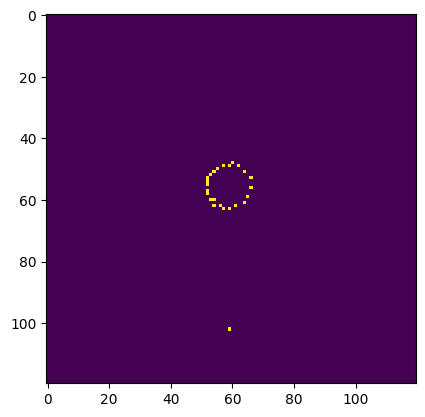

In [771]:
plt.imshow(tra, cmap='viridis')

In [772]:
# init_HH = [node.v, node.m, node.n, node.h]
# np.save('HH120.npy', init_HH) # Save data

In [773]:
# init_FHN = [node.v, node.w]
# np.save('FHN120.npy', init_FHN) # Save data

In [774]:
# init_LR = [node.v, node.m, node.h, node.j, node.d, node.f,node.X, node.Cai]
# np.save('LR120.npy', init_LR) # Save data

In [775]:
# init_FK = [node.v, node.u, node.w]
# np.save('FK120.npy', init_FK) # Save data

In [776]:
# Drawing Instantiation
# anim = Plotter(mem_data, l, v_min, v_max, node)
# Drawing membrane potential .gif
# anim.create_animation(frames=range(0, mem_data.shape[1], 100), interval=100, output_file='spiral.gif')